# Практическая работа №3


1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

In [ ]:
#!pip install xgboost

In [37]:
import numpy as np
import pandas as pd

import seaborn as sns
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, average_precision_score, auc

import warnings
warnings.simplefilter('ignore')

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


In [5]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [6]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [7]:
def cross_val_fit(classifier, X_train, y_train, X_test, y_test):
    #запустим кросс-валидацию
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    
    b=1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    roc_score=roc_auc_score(y_test.values, y_score)
    return y_score, [cv_score, cv_score_std, thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_score] 
    

In [8]:
def plt_roc_auc(y, y_pred):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y, y_pred, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve')
    #plt.savefig("ROC.png")
    plt.show()

создадим таблицу метрик

In [9]:
tbl=pd.DataFrame(columns=['F-Score', 'Precision', 'Recall', 'ROC'])

**логистическая регрессия**

CV score is 0.79+-0.009
Best Threshold=0.39, F-Score=0.730, Precision=0.647, Recall=0.838, ROC=0.784


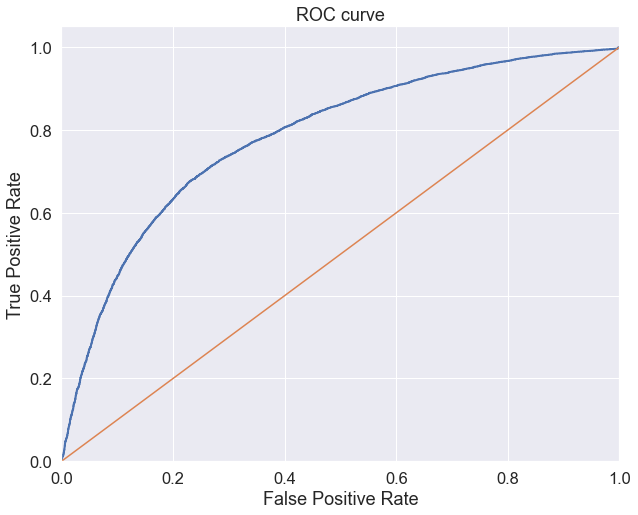

In [10]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

y_score, metrics = cross_val_fit(classifier, X_train, y_train, X_test, y_test)
print(f'CV score is {metrics[0]:.2f}+-{metrics[1]:.3f}')
print(f'Best Threshold={metrics[2]:.2f}, F-Score={metrics[3]:.3f}, Precision={metrics[4]:.3f}, Recall={metrics[5]:.3f}, ROC={metrics[6]:.3f}')
plt_roc_auc(y_test, y_score)
tbl.loc['LogReg']=metrics[3:]

**k ближайших соседей**

CV score is 0.69+-0.007
Best Threshold=0.40, F-Score=0.686, Precision=0.588, Recall=0.822, ROC=0.694


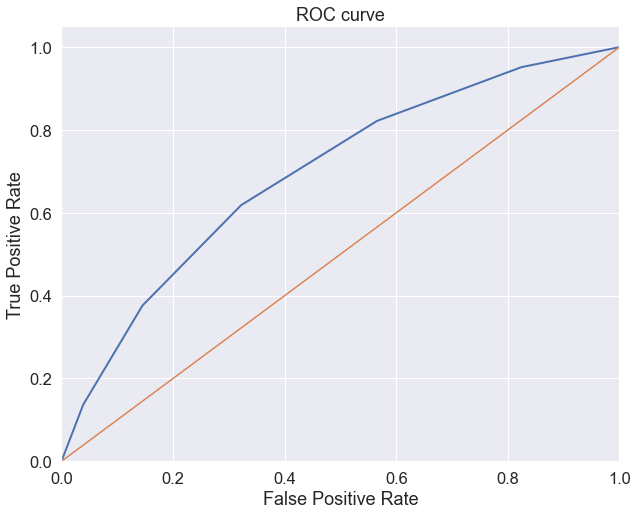

In [11]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', KNeighborsClassifier()),
])

y_score, metrics = cross_val_fit(classifier, X_train, y_train, X_test, y_test)
print(f'CV score is {metrics[0]:.2f}+-{metrics[1]:.3f}')
print(f'Best Threshold={metrics[2]:.2f}, F-Score={metrics[3]:.3f}, Precision={metrics[4]:.3f}, Recall={metrics[5]:.3f}, ROC={metrics[6]:.3f}')
plt_roc_auc(y_test, y_score)
tbl.loc['KNeighbors']=metrics[3:]

**XGBoost**

[16:22:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:23:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

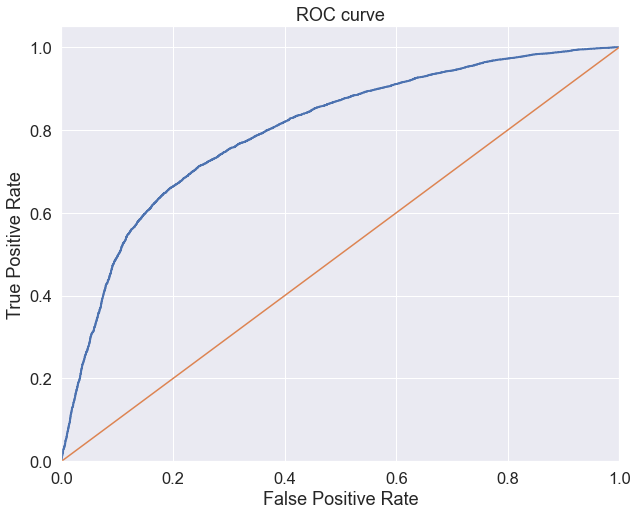

In [12]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(random_state = 42)),
])

y_score, metrics = cross_val_fit(classifier, X_train, y_train, X_test, y_test)
print(f'CV score is {metrics[0]:.2f}+-{metrics[1]:.3f}')
print(f'Best Threshold={metrics[2]:.2f}, F-Score={metrics[3]:.3f}, Precision={metrics[4]:.3f}, Recall={metrics[5]:.3f}, ROC={metrics[6]:.3f}')
plt_roc_auc(y_test, y_score)
tbl.loc['XGBoost']=metrics[3:]

**выведем таблицу метрик**

In [13]:
tbl

,F-Score,Precision,Recall,ROC
LogReg,0.730323,0.647431,0.837558,0.784035
KNeighbors,0.685863,0.588468,0.821889,0.694088
XGBoost,0.737890,0.665248,0.828341,0.797228


**Вывод: модель XGBoost справилась с задачей лучше других**

5. (опциональный вопрос) какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого, например, 1 к 1000).
p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:<br>
<br>
первая помечает 100 объектов как класс 1, но TP = 90<br>
вторая помечает 1000 объектов как класс 1, но TP такой же - 90<br>
Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [21]:
y=pd.Series([ 1 if i < 100 else 0 for i in range(100000)])

In [23]:
y_model1= pd.Series([ 1 if (9 < i) and (i < 110) else 0 for i in range(100000)])

In [26]:
y_model2= pd.Series([ 1 if (9 < i) and (i < 1010) else 0 for i in range(100000)])

In [38]:
def plt_metrics(y_true, pred):
    precision, recall, _ = precision_recall_curve(y_true, pred)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision_score(y_true, pred)))
    
    
    
    fpr_rf, tpr_rf, _ = roc_curve(y_true, pred)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    plt.figure(figsize=(8,8))
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.step(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))

    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()



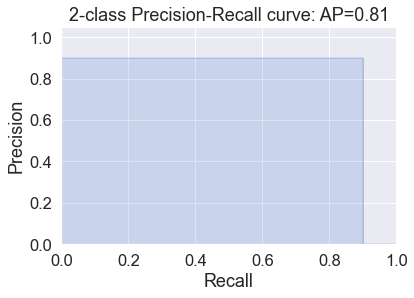

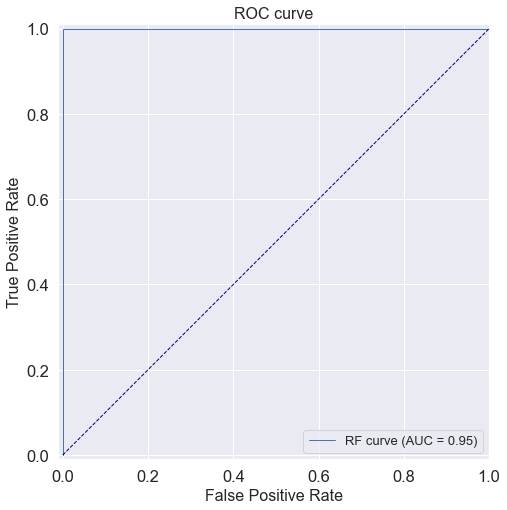

In [39]:
plt_metrics(y, y_model1)

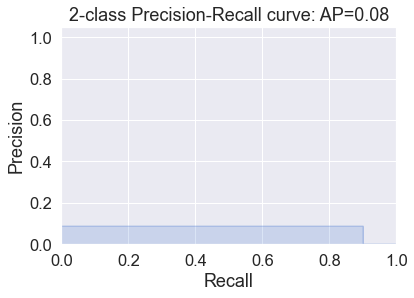

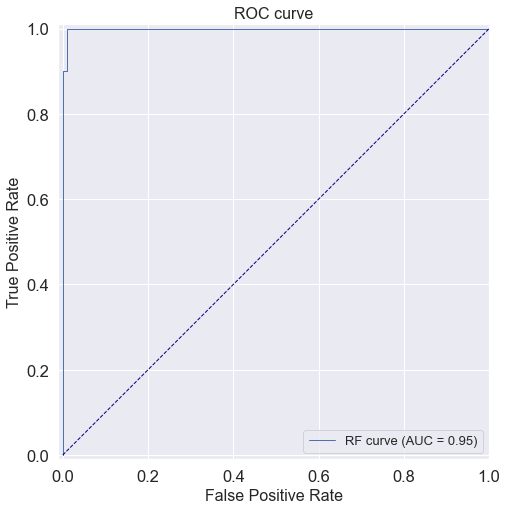

In [40]:
plt_metrics(y, y_model2)

**Вывод: Первая модель лучше так как у нее точность (presicion) значительно выше.**